# Imports

In [ ]:
!pip install estnltk==1.7.4

from estnltk.wordnet import Wordnet
wn = Wordnet()

import pandas as pd
from google.colab import files

import json
import os

from datetime import date, timedelta
import random
import numpy as np
import itertools

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/connections.json"

Mounted at /content/drive


# Loading in word frequency. <br>
"Tasakaalus korpuse lemmad sageduse järjekorras" can be obtained from [here](https://keeleressursid.ee/et/256-sagedusloendid)

In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

with open(file_name, "r", encoding="utf-8") as f:
    lines = f.readlines()

rows = []
for line in lines:
    split = line.strip().split()
    if len(split) >= 2:
        freq = split[0]
        sõna = split[1]
        rows.append((freq, sõna))

df = pd.DataFrame(rows, columns=["freq", "sõna"])
df["freq"] = pd.to_numeric(df["freq"], errors="coerce")
df = df.dropna(subset=["freq"])

n = 0
common_words = []
for synset in wn:
  word_str = synset.name.split(".")[0]
  if word_str in df["sõna"].values and word_str not in common_words:
    common_words += [word_str]
    n += 1
print(f"Total viable words found in common words list: {n}")


Saving lemma_kahanevas.txt to lemma_kahanevas.txt
Total viable words found in common words list: 19684


# Generating connections

In [ ]:
# If one letter added to end of 2nd word
def one_off(word1, word2):
    return len(word2) == len(word1) + 1 and word2[:-1] == word1

# Parts of words, such as car -> wheels
def get_meronyms(word, synset):
  meronyms = set()
  for meronym in synset.meronyms:
    meronyms.update(meronym.lemmas)
  return meronyms

# Holonyms - Unused for now
def get_holonyms(synset):
  holonyms = set()
  for holonym in synset.holonyms:
    h_lemmas = holonym.lemmas
    for lemma in h_lemmas:
      if word not in lemma:
        holonyms.add(lemma)
  return holonyms

# Synonyms
def get_lemmas(synset):
  lemmas = set()
  base_word = synset.lemmas[0].lower()

  for lemma in synset.lemmas[1:]:
    base_lemma = lemma.lower()
    if base_word in base_lemma or base_lemma in base_word: # Remove some of the simpler ones, this does not account for everything, but that's intended
      continue
    lemmas.add(lemma)
  return lemmas

# Children of word
def get_hyponyms(synset):
  hyponyms = set()
  all = synset.hyponyms
  if len(all) <= 4:
    all = synset.closure("hyponym")
  for hyponym in all:
    hyponyms.add(hyponym.name.split(".")[0])
  return hyponyms

# Words with 1 letter added to it, such as puu -> puur
def get_one_off(word, words):
  one_offs = set()
  for w in words:
    if one_off(word, w) and w not in one_offs:
      one_offs.add(w)
  return one_offs

def get_connections(word):
    synsets = wn[word]
    w_str = synsets[0].lemmas[0]
    parts = []
    synonyms = []
    hyponyms = []
    one_offs = []

    all_word_connections = [] # Every possible connection to this word

    for synset in synsets:
      # Parts
      syn_parts = list(get_meronyms(w_str, synset))
      if len(syn_parts) >= 4:
        parts.append(syn_parts)
        all_word_connections += syn_parts

      # Synonyms
      lemmas = list(get_lemmas(synset))
      if len(lemmas) >= 4:
        synonyms.append(lemmas)
        all_word_connections += lemmas

      # Hyponyms
      syn_hyponyms = list(get_hyponyms(synset))
      if len(syn_hyponyms) >= 4:
        hyponyms.append(syn_hyponyms)
        all_word_connections += syn_hyponyms

    # Words with 1 letter added at the end
    one_offs_word = list(get_one_off(w_str, common_words))
    if len(one_offs_word) >= 4:
      one_offs.append(one_offs_word)
      all_word_connections += one_offs_word

    return w_str, synsets[0].definition, all_word_connections, parts, list(synonyms), list(hyponyms), list(one_offs)


In [ ]:
i = 0
max_words = len(common_words)

all_connections = {}

for word in common_words:
  lemma, definition, all, parts, synonyms, hyponyms, one_offs = get_connections(word)

  # Tracking progress
  i += 1
  if i % 100 == 0:
    print(f"{i}/{max_words} words processed")

  # Words with less than 4 connections are useless for the game
  if len(all) < 4:
    continue
  all_connections[lemma] = [definition, all, parts, synonyms, hyponyms, one_offs]
print(f"{i}/{max_words} words processed")

100/19684 words processed
200/19684 words processed
300/19684 words processed
400/19684 words processed
500/19684 words processed
600/19684 words processed
700/19684 words processed
800/19684 words processed
900/19684 words processed
1000/19684 words processed
1100/19684 words processed
1200/19684 words processed
1300/19684 words processed
1400/19684 words processed
1500/19684 words processed
1600/19684 words processed
1700/19684 words processed
1800/19684 words processed
1900/19684 words processed
2000/19684 words processed
2100/19684 words processed
2200/19684 words processed
2300/19684 words processed
2400/19684 words processed
2500/19684 words processed
2600/19684 words processed
2700/19684 words processed
2800/19684 words processed
2900/19684 words processed
3000/19684 words processed
3100/19684 words processed
3200/19684 words processed
3300/19684 words processed
3400/19684 words processed
3500/19684 words processed
3600/19684 words processed
3700/19684 words processed
3800/19684

# Load / Save generated connections

In [ ]:
# Save
with open("/content/drive/My Drive/connections.json", "w") as file:
    json.dump(all_connections, file, indent=4)

In [ ]:
# Load
with open("/content/drive/My Drive/connections.json", "r") as file:
    all_connections = json.load(file)

# Data Display

In [ ]:
def print_connections(all_connections, amount):
  i = 0
  for word, details in all_connections.items():
    i += 1
    print(f"Word: {word}")
    print(f"  Definition: {details[0]}")

    print(f"  Parts of: {details[2] if details[2] else 'None'}")
    print(f"  Synonyms: {details[3] if details[3] else 'None'}")
    print(f"  Children: {details[4] if details[4] else 'None'}")
    print(f"  One-letter additions: {details[5] if details[5] else 'None'}")

    print("=" * 40)
    print(f"  Connections: {details[1] if details[1] else 'None'}")
    print("=" * 40)

    if i == amount:
      break

In [ ]:
def print_connection(word, all_connections):
  print(f"Word: {word}")
  print(f"  Definition: {all_connections[word][0]}")
  print(f"  Parts of: {all_connections[word][2] if all_connections[word][2] else 'None'}")
  print(f"  Synonyms: {all_connections[word][3] if all_connections[word][3] else 'None'}")
  print(f"  Children: {all_connections[word][4] if all_connections[word][4] else 'None'}")
  print(f"  One-letter additions: {all_connections[word][5] if all_connections[word][5] else 'None'}")
  print("=" * 40)
  print(f"  Connections: {all_connections[word][1] if all_connections[word][1] else 'None'}")
  print("=" * 40)

In [ ]:
print_connection("puu", all_connections)

Word: puu
  Definition: pikaealine kõrgema tüvega puittaim
  Parts of: None
  Synonyms: None
  Children: [['kruvipuu', 'viljapuu', 'säilik', 'nelgipuu', 'emalepp', 'kordaiit', 'heinpuu', 'kakao', 'rimu', 'guajakipuu', 'jalakapuu', 'ilang', 'jändrik', 'ahvileivapuu', 'leivapuu', 'mastipuu', 'jaanileivapuu', 'nöörpuu', 'pähklipuu', 'koola', 'sügamispuu', 'seemnepuu', 'põõsaspuu', 'mudelpuu', 'bonsai', 'teepuu', 'põlispuu', 'diospüür', 'kuivik', 'kaneelipuu', 'manglipuu', 'palm', 'võrapuu', 'kummipuu', 'vahtralehik', 'okaspuu', 'troopikapuu', 'spaleerpuu', 'meiud', 'pöök', 'eukalüpt', 'pargipuu', 'vormpuu', 'rosettpuu', 'ristipuu', 'plaatan', 'ilupuu', 'saar', 'kampripuu', 'miinuspuu', 'ajepuu', 'võrse', 'künnapuu', 'plusspuu', 'lehtpuu'], ['keelikas', 'toobripuu', 'kaust', 'kook', 'nott', 'ader', 'lasila', 'jalas', 'rõhtpuu', 'triikpuu', 'jugu', 'katlapuu'], ['pine', 'lapats', 'sugar', 'lõmm', 'noalõks'], ['saematerjal', 'korvipeerg', 'männipuit', 'laud', 'ajupuit', 'kogupuit', 'jalakas'

In [ ]:
print_connections(all_connections, 500)

# Game Data Generation

Word Definitions

In [ ]:
word_defs = {}

n = 0
for word in wn:
  n += 1
total = n

for i,word in enumerate(wn):
  wdef = word.definition
  wstr = word.name.split(".")[0]
  word_defs[wstr] = wdef
  if i % 1000 == 1:
    print(f"{i}/{total}")

with open("/content/drive/My Drive/definitions.json", "w") as file:
    json.dump(word_defs, file, indent=4)

1/92212
1001/92212
2001/92212
3001/92212
4001/92212
5001/92212
6001/92212
7001/92212
8001/92212
9001/92212
10001/92212
11001/92212
12001/92212
13001/92212
14001/92212
15001/92212
16001/92212
17001/92212
18001/92212
19001/92212
20001/92212
21001/92212
22001/92212
23001/92212
24001/92212
25001/92212
26001/92212
27001/92212
28001/92212
29001/92212
30001/92212
31001/92212
32001/92212
33001/92212
34001/92212
35001/92212
36001/92212
37001/92212
38001/92212
39001/92212
40001/92212
41001/92212
42001/92212
43001/92212
44001/92212
45001/92212
46001/92212
47001/92212
48001/92212
49001/92212
50001/92212
51001/92212
52001/92212
53001/92212
54001/92212
55001/92212
56001/92212
57001/92212
58001/92212
59001/92212
60001/92212
61001/92212
62001/92212
63001/92212
64001/92212
65001/92212
66001/92212
67001/92212
68001/92212
69001/92212
70001/92212
71001/92212
72001/92212
73001/92212
74001/92212
75001/92212
76001/92212
77001/92212
78001/92212
79001/92212
80001/92212
81001/92212
82001/92212
83001/92212
84001

Puzzles

In [ ]:
class Puzzle:
  def __init__(self, name, theme, difficulty, connections):
    if len(connections) < 4:
      raise ValueError("Puzzle must have at least 4 connections.")
    self.name = name
    self.theme = theme
    self.difficulty = difficulty
    self.connections = connections

  def get_name(self):
    return self.name

  def to_array(self):
    return [self.name, self.theme, self.difficulty, self.connections]

Difficulty Calculation

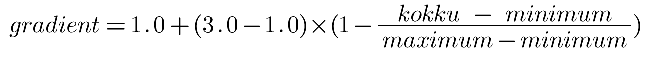

In [ ]:
maximum = 100
minimum = df["freq"].min()

df["difficulty_mod"] = np.where(
    df["freq"] > maximum,
    1.0,
    1.0 + (3.0 - 1.0) * (1 - (df["freq"] - minimum) / (maximum - minimum)) # Provides a gradient value for difficulty
)

def get_diff_word(word, df):
    el = df.loc[df["sõna"] == word, "difficulty_mod"]
    if el.empty:
      return None
    return el.values[0]

# Finds if two words have 3 or more letters in common
def closeness(word1, word2):
    len1 = len(word1)
    len2 = len(word2)

    for i in range(len1):
        for j in range(len2):
            n = 0
            while i + n < len1 and j + n < len2 and word1[i + n] == word2[j + n]:
                n += 1
                if n >= 3:
                    return True
    return False

# Finds the difficulty of a puzzle
def calc_difficulty(puzzle_type, words):
  dif = 0
  w_dif = 0

  subword = False

  for word in words:
    if word in common_words:
      w_dif = get_diff_word(word, df)
    else: # If we can't find the word's difficulty we'll default to max
      w_dif = 3
    dif += w_dif

    if puzzle_type == 4:
      for word2 in words:
        if closeness(word, word2):
          subword = True
          break
  dif = dif / len(words)

  match puzzle_type:
    case 2: # Part of
      return dif * 1.5
    case 3: # Synonym
      return dif
    case 4: # Children
      if subword:
        return dif * 0.5
      return dif * 2
    case 5: # One-letter additions
      return dif * 1.7
  return dif

In [ ]:
def generate_puzzle(existing_puzzles, connections):
  viable = False

  while not viable and connections:
    puzzle_choice = next(iter(connections))
    puzzle_words = connections[puzzle_choice]

    if any(puzzle_choice == existing_puzzle.get_name() for existing_puzzle in existing_puzzles):
      connections.pop(puzzle_choice)
      continue

    if len(puzzle_words[1]) < 4:
      connections.pop(puzzle_choice)
      continue

    valid_puzzle_types = set()

    # Check all types of puzzles for length, 4 is minimum possible for a puzzle
    for i in range(2,6):
      for word_set in puzzle_words[i]:
        if len(word_set) >= 4:
          viable = True
          valid_puzzle_types.add(i)
    connections.pop(puzzle_choice)

  if not viable: # No puzzles left
    return None

  found_puzzles = []
  for puzzle_type in valid_puzzle_types:

    match puzzle_type:
      case 2: # Part of
        puzzle_type_str = f"{puzzle_choice} osa"
      case 3: # Synonym
        puzzle_type_str = f"{puzzle_choice} sünonüüm"
      case 4: # Children
        puzzle_type_str = f"{puzzle_choice} alamsõna"
      case 5: # One-letter additions
        puzzle_type_str = f"{puzzle_choice} ühe ekstra tähega"

    # Gets every possible combination for this type of puzzle
    for synset_words in puzzle_words[puzzle_type]:
      if len(synset_words) < 4:
        continue
      synset_list = list(synset_words)
      if len(synset_list) > 8: # If we have too many variations puzzles are cut short to allow for more variety with sensible generation time
        synset_list = synset_list[:8]

      puzzles = itertools.combinations(synset_list, 4) # Get's all word combinations
      for combo in puzzles:
        puzzle_dif = calc_difficulty(puzzle_type, combo)
        found_puzzles.append(Puzzle(puzzle_choice, puzzle_type_str, puzzle_dif, list(combo)))


  return found_puzzles





In [ ]:
existing_puzzles = []
i = 0

while all_connections:
  found_puzzles = generate_puzzle(existing_puzzles, all_connections)
  if found_puzzles:
    existing_puzzles += found_puzzles
  i += 1
  if i % 10 == 0:
    print(f"{len(all_connections)} puzzles left")

In [ ]:
jsonified_puzzles = []
for puzzle in existing_puzzles:
  jsonified_puzzles.append(puzzle.to_array())

In [ ]:
# Save
with open("/content/drive/My Drive/puzzles.json", "w") as file:
    json.dump(jsonified_puzzles, file, indent=4)

In [ ]:
# Load
with open("/content/drive/My Drive/puzzles.json", "r") as file:
    jsonified_puzzles = json.load(file)

In [ ]:
print(f"{len(jsonified_puzzles)} puzzles generated.")